# 1. 모듈 및 분석 환경 설정

### - 1. 모듈 불러오기

In [1]:
import torch

#딥러닝 네트워크 기본구성 요소
import torch.nn as nn

#딥러닝에 자주 사용되는 함수 모듈
import torch.nn.functional as F

#가중치 추정에 필요한 최적화 알고리즘
import torch.optim as optim

#데이터셋 과 모델 구조 및 이미지 변환 기술
from torchvision import datasets, transforms

#데이터 차트 및 시각화
#주피터노트북은 브라우저에서 보기위해 inline 필수
from matplotlib import pyplot as plt
%matplotlib inline

### - 2. 분석 환경 설정

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)
'''
gpu : cuda
cpu : cpu
'''

Current cuda device is cuda


'\ngpu : cuda\ncpu : cpu\n'

### - 3. Hyper Parameter 지정

In [3]:
'''
batch_size : 모델 가중치를 한 번 업데이트 시킬 때 사용되는 샘플 단위 개수
epoch_num : 학습 데이터를 모두 사용하여 학습하는 기본 단위 횟수
learning_rate : 가중치 업데이트의 정도
'''
batch_size = 50
epoch_num = 15
learning_rate = 0.0001

# 2. 데이터 불러오기

### - 1. MNIST 데이터 불러오기

In [4]:
'''
root : MNIST 데이터를 저장할 물리적 공간 위치
train : True/False의 논리값으로 데이터를 학습용으로 사용할 것인지 지정
download : True를 입력하면 root 옵션에서 지정된 위치에 데이터 저장.
           처음 시행이 아니고 이미 저장된 데이터가 있다면 False
transform : MNIST 데이터를 저장과 동시에 전처리를 할 수 있는 옵션
            PyTorch는 입력 데이터로 Tensor를 사용하므로 이미지를 Tensor로 변형하는
            전처리 transforms.ToTensor() 사용
'''
train_data = datasets.MNIST(root = './data', train = True, download = True,
                           transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False,
                          transform = transforms.ToTensor())

print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


### - 2. MNIST 데이터 확인하기

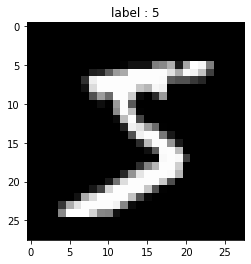

In [5]:
'''
MNIST는 3차원텐서임(1, 28, 28)
squeeze() 함수는 크기가 1인 차원을 없앰
'''

image, label = train_data[0]

plt.imshow(image.squeeze().numpy(), cmap = 'gray')
plt.title('label : %s' % label)
plt.show()

### - 3. 미니 배치 구성하기

In [6]:
'''
dataset : 미니 배치로구성할 데이터
batch_size : 미니 배치의 사이즈
shuffle: 시계열 데이터가 아닌 경우, 데이터의 순서에 대해서는 학습하지 못하도록 랜덤으로 섞음
torch_size[50, 1, 28,28] : batch_size, channel, width, height

'''
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                          batch_size = batch_size,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                         batch_size = batch_size,
                                         shuffle = True)

first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25} | {}'.format('name','type', 'size'))
print('{:15s} | {:<25} | {}'.format('Num of Batch','', 
                                   len(train_loader)))
print('{:15s} | {:<25} | {}'.format('first_batch',str(type(first_batch)), 
                                   len(first_batch)))
print('{:15s} | {:<25} | {}'.format('first_batch[0]',
                                    str(type(first_batch[0])), 
                                    first_batch[0].shape))
print('{:15s} | {:<25} | {}'.format('first_batch[1]',
                                    str(type(first_batch[1])), 
                                    first_batch[1].shape))
                                    


name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


In [11]:
#nn.Module 상속받는 CNN클래스 정의
class CNN(nn.Module):
    # 가중치 정의
    def __init__(self):
        # nn.Module 클래서 속성을 상속받고 초기화
        super(CNN, self).__init__()
        
        # in_channels = 1 : tensor의 채널 크기
        # out_channels = 32 : conv1의 출력크기. conv2의 입력크기와 같아야함
        # kernel_size = 3 : Filter의 크기. 
        #                   Scalar 값으로 지정하면 가로와 세로의 크기가 같은 2D Filter 생성
        #                   kernel_size = 3 은 (3x3)Filter임
        # stride = 1 : Filter가 움직이는 단위
        # padding : 옵션을 지정하지 않아 padding = 0이 적용되어 시행되지 않음
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        # 0.25 확률의 dropout1 지정
        self.dropout1 = nn.Dropout2d(0.25)
        # 0.5 확률의 dropout1 지정
        self.dropout2 = nn.Dropout2d(0.5)
        
        # Fully-connected Layer 정의
        # in_features = 9216, out_features = 128
        # 9216 크기의 벡터를 128 크기의 벡터로 변환하는 가중치 설계
        self.fc1 = nn.Linear(9216, 128)
        # fc1 에서 출력된 128 크기의 벡터를 MNIST의 클래스 개수인 10 크기의 벡터로 변환
        self.fc2 = nn.Linear(128,10)
        
    # Feed Forward 연산 정의
    def forward(self, x):
        # 입력 이미지 conv1 레이어 통과
        x = self.conv1(x)
        # ReLU 활성함수 적용
        # 활성 함수는 단순 연산이므로 __init__에서 정의한 학습 가중치 없음
        x = F.relu(x)
        # conv2 레이어 통과
        x = self.conv2(x)
        # ReLU 활성함수 적용
        x = F.relu(x)
        # (2x2) 크기의 filter로 max pooling 적용
        # pooling layer는 단순연산이므로 학습할 가중치 없음
        x = F.max_pool2d(x, 2)
        # 0.25 확률의 dropout1 적용
        x = self.dropout1(x)
        # Fully-connected Layer 통과하기전, 고차원의 Tensor를 1차원의 벡터로 변환
        # 2개의 Convolutional Layer와 1번의 max pooling으로 만들어진 [64, 12, 12]크기의 3차원 Tensor가 9216벡터로 변환됨
        x = torch.flatten(x, 1)
        # 9216 크기의 벡터를 128 크기의 벡터로 학습하는 fc1 통과
        x = self.fc1(x)
        # ReLU 활성함수 적용
        x = F.relu(x)
        # 0.5 확률의 dropout2 적용
        x = self.dropout2(x)
        # 2번째 Fully-connected Layer인 fc2를 통과하면서 벡터의 사이즈가 128에서 10으로 줄어듦
        x = self.fc2(x)
        # 최종 출력값으로 log-softmax 계산
        # softmax보다 연산 속도를 높일 수 있음
        output = F.log_softmax(x, dim = 1)
        return output

### - 4. Optimizer 및 손실 함수 정의

In [12]:
# CNN 클래스를 이용해 model이라는 인스턴스 생성
# 1-2에서 지정한 device 인식
model = CNN().to(device)

# 손실 함수를 최소로 하는 가중치를 찾기 위해 Adam 알고리즘의 optimizer 지정
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# MNIST는 다중 클래스 분류 문제이기에 교차 엔트로피(CrossEntropy)를 손실 함수로 설정
criterion = nn.CrossEntropyLoss()

### - 5. 설계한 CNN 모형 확인하기

In [13]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### - 6. 모델 학습

In [14]:
# CNN클래스가 저장된 model 인스턴스를 학습 모드로 실행할 것을 명시
model.train()
# 보조 인덱스 지정
i = 0

# 미리 지정해둔 epoch 수만큼 반복 학습 for문 선언
for epoch in range(epoch_num):
    # 학습 데이터를 batch_size로 나눈 만큼 반복 수행
    # train_loader는 매 시행마다 미니 배치의 데이터와 정답을 data와 target에 저장
    for data, target in train_loader:
        # 미니 배치의 데이터를 기존에 지정한 장비 device에 할당
        data = data.to(device)
        # 미니 배치의 정답을 기존에 지정한 장비 device에 할당
        target = target.to(device)
        # 학습 시작 전, 이전 반복 시행에서 저장된 optimizer의 gradient 초기화
        optimizer.zero_grad()
        # 미니 배치 데이터를 모델에 통과시키는 Feed Forward 연산으로 결괏값 계산
        output = model(data)
        # 계산된 결괏값과 실제 정답으로 손실 함수 계산
        loss = criterion(output,target)
        # 손실 함수를 통해 Gradient 계산
        loss.backward()
        # 위에서 계산된 Gradient를 통해 모델의 가중치 업데이트
        optimizer.step()
        # 1000번째 시행마다 손실 함수를 확인하기 위한 if문
        if i % 1000 == 0:
            # 손실 함수 출력
            print('Train Step: {}/tLoss: {:.3f}'.format(i, loss.item()))
        i += 1

C:\Users\rk401\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 0/tLoss: 2.291
Train Step: 1000/tLoss: 0.381
Train Step: 2000/tLoss: 0.200
Train Step: 3000/tLoss: 0.180
Train Step: 4000/tLoss: 0.108
Train Step: 5000/tLoss: 0.034
Train Step: 6000/tLoss: 0.140
Train Step: 7000/tLoss: 0.038
Train Step: 8000/tLoss: 0.077
Train Step: 9000/tLoss: 0.029
Train Step: 10000/tLoss: 0.015
Train Step: 11000/tLoss: 0.082
Train Step: 12000/tLoss: 0.005
Train Step: 13000/tLoss: 0.075
Train Step: 14000/tLoss: 0.066
Train Step: 15000/tLoss: 0.029
Train Step: 16000/tLoss: 0.017
Train Step: 17000/tLoss: 0.004


### - 7. 모델 평가

In [15]:
# 평가 모드 실행
# eval 함수를 호출하면 Dropout이 적용되지 않고 Batch-Normalization도 평가모드로 전환됨
model.eval()
# 정답 개수를 저장할 변수
correct = 0

# 테스트 데니터를 batch_size로 나눈 만큼 반복 수행됨
# test_loader는 매 시행마다 미니 배치의 데이터와 정답을 data와 target에 저장
for data, target in test_loader:
    # 미니 배치의 데이터를 기존에 저장한 장비 device에 할당
    data = data.to(device)
    # 미니 배치의 정답을 기존에 지정한 장비 device에 할당
    target = target.to(device)
    # 미니 배치 데이터를 모델에 통과시켜 결괏값 계산
    output = model(data)
    # Log-Softmax 값이 가장 큰 인덱스를 예측값으로 저장
    prediction = output.data.max(1)[1]
    # 실제 정답과 예측값이 같으면 True, 다르면 False인 논리값으로 구성된 벡터 더하기
    # 미니 배치 중 정답의개수를구하고 반복 시행마다 누적해서 더해줌
    correct += prediction.eq(target.data).sum()
    
# 전체 테스트 데이터 중 맞춘 개수의 비율을 통해 정확도 계산하여 출력    
print('Test set : Accuracy : {:.2f}%'.format(100 * correct / len(test_loader.dataset)))

Test set : Accuracy : 98.96%
